# Loan Approval Prediction via PySpark

## Project Overview
Predict loan approval (Yes/No) using applicant and loan details. The workflow uses PySpark MLlib for preprocessing, feature engineering, Logistic Regression, evaluation, and visualization.

## Dataset
The dataset contains loan applications with fields such as income, education, dependents, employment, loan amount, credit history, and approval status.

**Target variable:** `Loan_Status` (Y = approved, N = rejected)

## Workflow
1. Import the required libraries
2. Load data into a Spark DataFrame
3. Data exploration
3. Data cleaning and preprocessing with visualizations
4. Encode categorical features with `StringIndexer` and `OneHotEncoder`, then combine all features into a single vector using `VectorAssembler`.
5. Train Logistic Regression
6. Evaluate using Accuracy and F1-score

## Libraries Used
- pyspark
- pandas
- matplotlib
- seaborn
- sklearn

----
----
### 1. Importing the depedencies

In [ ]:
# Data Manipulation and Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# PySpark Basic
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col

# Pyspark Machine Learning
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

import warnings
warnings.filterwarnings("ignore")

----
### 2. Loading dataset into Spark DataFrame
</span>

In [2]:
# Initializing Spark Session
spark = SparkSession.builder.appName("Loan_Prediction").getOrCreate()

# Importing the dataset
data = spark.read.csv("Loan_Prediction_Data.csv", header=True, inferSchema=True)

data.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      NULL|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

----
### 3. Data Exploration

In [3]:
data.printSchema()
print("-" * 100)
print(data.columns)
print("-" * 100)
print(data.dtypes)

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)

----------------------------------------------------------------------------------------------------
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
----------------------------------------------------------------------------------------------------
[('Loan_ID', 'string'),

In [4]:
print(data.groupBy('Loan_Status').count().show())

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          Y|  422|
|          N|  192|
+-----------+-----+

None


In [5]:
data.select("Credit_History", "Loan_Status").groupBy("Loan_Status").agg(F.avg("Credit_History").alias("Avg_Credit_History")).show()

# People with credit history closer to one are more likely to get loans.

+-----------+------------------+
|Loan_Status|Avg_Credit_History|
+-----------+------------------+
|          Y|0.9818181818181818|
|          N|0.5418994413407822|
+-----------+------------------+



In [6]:
data.select("Gender", "Loan_Status").groupBy("Loan_Status", "Gender").count().show()

# More male applicants and more male approvals
# Null values will be dealt later

+-----------+------+-----+
|Loan_Status|Gender|count|
+-----------+------+-----+
|          N|Female|   37|
|          Y|  NULL|    8|
|          Y|Female|   75|
|          N|  NULL|    5|
|          Y|  Male|  339|
|          N|  Male|  150|
+-----------+------+-----+



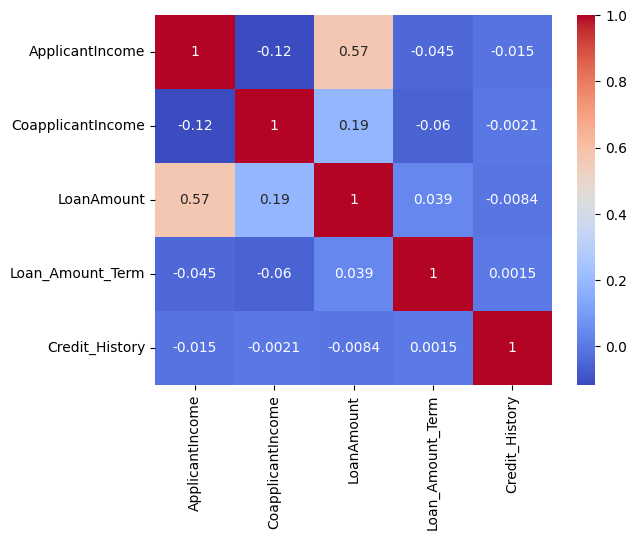

In [7]:
# Correlation Matrix:

numeric_cols = ["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term","Credit_History"]
pdf = data.select(numeric_cols).toPandas()
corr = pdf.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# As the applicant's income increases, the amount of the loan they apply for also tends to increase.


----
### 4. Data Cleaning and Preprocessing

In [8]:
# Checking for missing values
data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|    13|      3|        15|        0|           32|              0|                0|        22|              14|            50|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [ ]:
# Fill null values for all columns:

numeric_cols_null = ["LoanAmount","Loan_Amount_Term"]
categorical_cols_null = ["Gender","Married","Dependents","Self_Employed","Credit_History"]

for col in numeric_cols_null:
    mean = data.select(F.mean(data[col])).collect()[0][0]
    data = data.na.fill(mean, [col])

for col in categorical_cols_null:
    mode = data.groupBy(col).count().orderBy('count', ascending=False).first()[0]
    data = data.na.fill(mode, [col])

In [10]:
# All Null values filled
data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|     0|      0|         0|        0|            0|              0|                0|         0|               0|             0|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



----
### Data Visualizations

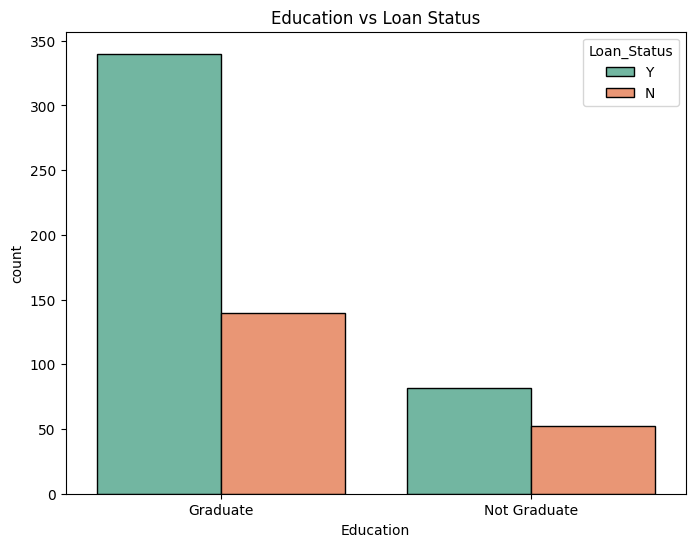

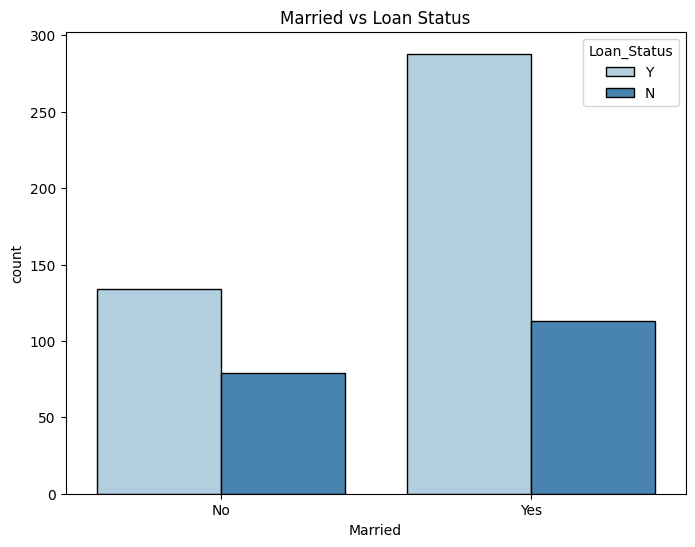

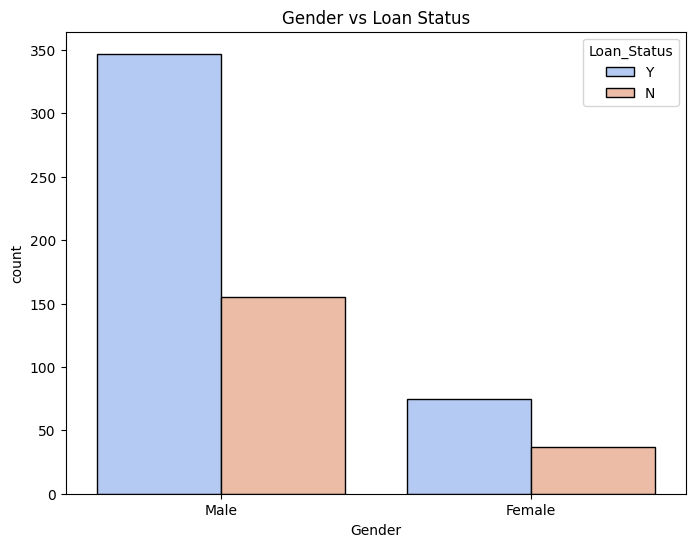

In [ ]:
pdf = data.toPandas()

# Education vs Loan Status
plt.figure(figsize=(8, 6))
sns.countplot(x="Education", hue="Loan_Status", data=pdf, edgecolor="black", palette= "Set2")
plt.title("Education vs Loan Status")
plt.show()

# Married vs Loan Status
plt.figure(figsize=(8, 6))
sns.countplot(x="Married", hue="Loan_Status", data=pdf, edgecolor="black", palette= "Blues")
plt.title("Married vs Loan Status")
plt.show()

# Gender vs Loan Status
plt.figure(figsize=(8, 6))
sns.countplot(x="Gender", hue="Loan_Status", data=pdf, edgecolor="black", palette="coolwarm")
plt.title("Gender vs Loan Status")
plt.show()

----
### 5. Feature Engineering: Categorical Encoding and Vector Assembly

In [12]:
# Label indexer
label_indexer = StringIndexer( inputCol="Loan_Status", outputCol="Loan_Status_index")

# Categorical indexers
categorical_cols = ["Gender","Married","Dependents","Education","Self_Employed","Property_Area"]
indexers = [ StringIndexer(inputCol=c, outputCol=f"{c}_index") for c in categorical_cols ]

# One-hot encoders
encoders = [OneHotEncoder( inputCols=[f"{c}_index"], outputCols=[f"{c}_encoded"], dropLast=False) for c in categorical_cols]

# VectorAssembler
numeric_cols = ["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term","Credit_History"]
feature_cols = [f"{c}_encoded" for c in categorical_cols] + numeric_cols

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

preprocess_pipeline = Pipeline(stages=[label_indexer] + indexers + encoders + [assembler])

# Fit preprocessing and transform
processed_data = preprocess_pipeline.fit(data).transform(data)
processed_data.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------------+------------+-------------+----------------+---------------+-------------------+-------------------+--------------+---------------+------------------+-----------------+---------------------+---------------------+--------------------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|Loan_Status_index|Gender_index|Married_index|Dependents_index|Education_index|Self_Employed_index|Property_Area_index|Gender_encoded|Married_encoded|Dependents_encoded|Education_encoded|Self_Employed_encoded|Property_Area_encoded|            features|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+----------

----

### 6. Model Training

In [13]:
# Train-test split
train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression model
lr = LogisticRegression( featuresCol="features", labelCol="Loan_Status_index")

# Fit LR model
lr_model = lr.fit(train_data)

# Predictions
pred = lr_model.transform(test_data)
pred.select("Loan_Status","Loan_Status_index","prediction","probability").show(5)


+-----------+-----------------+----------+--------------------+
|Loan_Status|Loan_Status_index|prediction|         probability|
+-----------+-----------------+----------+--------------------+
|          Y|              0.0|       0.0|[0.83253216505644...|
|          Y|              0.0|       0.0|[0.74788254915643...|
|          Y|              0.0|       0.0|[0.83202464179686...|
|          N|              1.0|       0.0|[0.74008156842011...|
|          Y|              0.0|       0.0|[0.80913146662578...|
+-----------+-----------------+----------+--------------------+
only showing top 5 rows



### 7. Model Evaluation

In [ ]:
acc = MulticlassClassificationEvaluator( labelCol="Loan_Status_index", predictionCol="prediction", metricName="accuracy").evaluate(pred)
f1 = MulticlassClassificationEvaluator( labelCol="Loan_Status_index", predictionCol="prediction", metricName="f1").evaluate(pred)
recall = MulticlassClassificationEvaluator( labelCol="Loan_Status_index", predictionCol="prediction", metricName="weightedRecall").evaluate(pred)
precision = MulticlassClassificationEvaluator( labelCol="Loan_Status_index", predictionCol="prediction", metricName="weightedPrecision").evaluate(pred)

print(f"Recall: {recall*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Accuracy: {acc*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

Recall: 78.35%
Precision: 84.03%
Accuracy: 78.35%
F1 Score: 75.85%


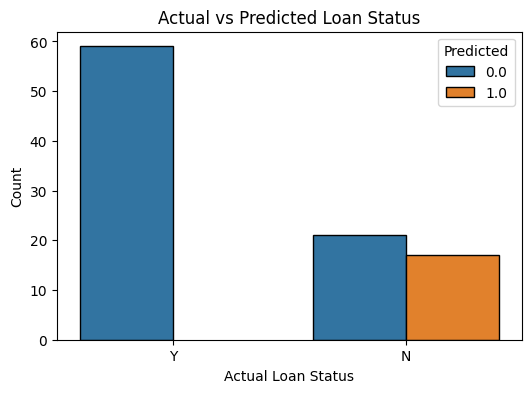

In [ ]:
# Bar chart: actual vs predicted
pdf = pred.select("Loan_Status", "prediction").toPandas()
plt.figure(figsize=(6,4))
sns.countplot(x="Loan_Status", hue="prediction", data=pdf, edgecolor="black")
plt.title("Actual vs Predicted Loan Status")
plt.xlabel("Actual Loan Status")
plt.ylabel("Count")
plt.legend(title="Predicted")
plt.show()

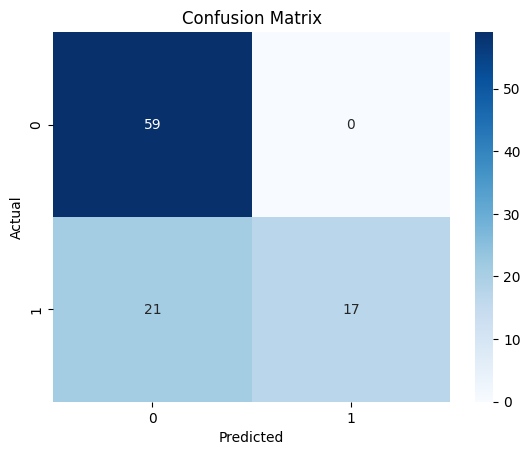

In [ ]:
pdf = pred.select("Loan_Status_index","prediction").toPandas()
cm = confusion_matrix(pdf["Loan_Status_index"], pdf["prediction"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# End of work